# Gradient Boosting Machines (GBMs) with XGBoost

## Problem Statement

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

I'll be using gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

- We are working with Rossman Dataset

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Data fields

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Downloading the Data

We can download the dataset from Kaggle and import directly into the Jupyter notebook using the `pandas` library. 

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
# Importing datasets
 
store_data = pd.read_csv("store.csv")
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
train_data = pd.read_csv("train.csv")
train_data.head(5)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21564\1925426325.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test_data= pd.read_csv("test.csv")
test_data = test_data.drop(columns= "Id")
test_data.head(5)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,1.0,1,0,0
1,3,4,2015-09-17,1.0,1,0,0
2,7,4,2015-09-17,1.0,1,0,0
3,8,4,2015-09-17,1.0,1,0,0
4,9,4,2015-09-17,1.0,1,0,0


Let's merge the information from `store_df` into `train_df` and `test_df` to get a richer set of features for each row of the training set. 

In [5]:
merged_train_data = train_data.merge(store_data, how = "left", on="Store")
merged_train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
merged_test_data = test_data.merge(store_data, how= 'left', on= "Store")
merged_test_data

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


I am using Pandas Profiling for creating a EDA Report.

In [73]:
from pandas_profiling import ProfileReport

In [74]:
profile = ProfileReport(merged_train_data, explorative=True)
profile.to_file("Rossmann Sales EDA.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [7]:
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [8]:
merged_train_data["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
# Convert '0' values to int
# merged_train_data["StateHoliday"] = merged_train_data["StateHoliday"].replace('0', 0).astype(int)

# Replace 0 with a specific value, for example, 'NotHoliday'
replacement_value = 'NotHoliday'
merged_train_data["StateHoliday"] = merged_train_data["StateHoliday"].replace('0', replacement_value)
merged_train_data["StateHoliday"] = merged_train_data["StateHoliday"].replace(0, replacement_value)


# Verify the changes
print(merged_train_data["StateHoliday"].unique())

['NotHoliday' 'a' 'b' 'c']


In [10]:
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      41088 non-null  int64  
 1   DayOfWeek                  41088 non-null  int64  
 2   Date                       41088 non-null  object 
 3   Open                       41077 non-null  float64
 4   Promo                      41088 non-null  int64  
 5   StateHoliday               41088 non-null  object 
 6   SchoolHoliday              41088 non-null  int64  
 7   StoreType                  41088 non-null  object 
 8   Assortment                 41088 non-null  object 
 9   CompetitionDistance        40992 non-null  float64
 10  CompetitionOpenSinceMonth  25872 non-null  float64
 11  CompetitionOpenSinceYear   25872 non-null  float64
 12  Promo2                     41088 non-null  int64  
 13  Promo2SinceWeek            23856 non-null  flo

In [11]:
merged_test_data["StateHoliday"].unique()

array(['0', 'a'], dtype=object)

In [12]:
# Replace 0 with a specific value, for example, 'NotHoliday'
replacement_value = 'NotHoliday'
merged_test_data["StateHoliday"] = merged_test_data["StateHoliday"].replace('0', replacement_value)

# Verify the changes
print(merged_test_data["StateHoliday"].unique())

['NotHoliday' 'a']



### Date

First, let's convert `Date` to a `datetime` column and extract different parts of the date.

In [13]:
def date_prepocessing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [14]:
date_prepocessing(merged_test_data)

In [15]:
date_prepocessing(merged_train_data)

In [16]:
merged_train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,NotHoliday,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,NotHoliday,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,NotHoliday,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,NotHoliday,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,NotHoliday,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [17]:
print("Sales when stores are closed", merged_train_data[merged_train_data.Open == 0].Sales.value_counts())

Sales when stores are closed 0    172817
Name: Sales, dtype: int64


Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [18]:
merged_train_data = merged_train_data[merged_train_data.Open == 1].copy()
merged_train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,NotHoliday,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,NotHoliday,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,NotHoliday,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,NotHoliday,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,NotHoliday,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [19]:
def competition_months(df):
    # The code is calculating the number of months since a competition opened for each row in the DataFrame `df`.
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [20]:
competition_months(merged_train_data)
competition_months(merged_test_data)

In [21]:
# Let's view the results of the new columns we've created.
merged_train_data[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
576035,2014-01-31,6470.0,2004.0,12.0,109.0
643604,2013-12-02,27150.0,NaN,NaN,0.0
249083,2014-12-18,520.0,NaN,NaN,0.0
999014,2013-01-17,560.0,2011.0,1.0,24.0
977719,2013-02-05,1420.0,2012.0,10.0,4.0
691741,2013-10-19,1630.0,2009.0,9.0,49.0
528566,2014-03-15,1200.0,2007.0,11.0,76.0
15311,2015-07-18,140.0,2006.0,3.0,112.0
603599,2014-01-06,720.0,2004.0,11.0,110.0
632685,2013-12-11,4360.0,2005.0,10.0,98.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [22]:
def checking_promo_month(row):
    month_to_str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month_to_str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_columns(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month (if we have same month than the IsPromoMonth is equal to 1 else 0)
    df['IsPromo2Month'] = df.apply(checking_promo_month, axis=1) * df['Promo2']

In [23]:
promo_columns(merged_train_data)
promo_columns(merged_test_data)

Let's view the results of the columns we've created.

In [24]:
merged_train_data[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
775823,2013-08-05,0,NaN,NaN,NaN,0.000000,0
286116,2014-11-08,0,NaN,NaN,NaN,0.000000,0
524724,2014-03-18,1,2012.0,22.0,"Jan,Apr,Jul,Oct",21.704918,0
513578,2014-03-28,0,NaN,NaN,NaN,0.000000,0
689122,2013-10-22,1,2011.0,48.0,"Mar,Jun,Sept,Dec",22.852459,0
783579,2013-07-29,1,2012.0,40.0,"Mar,Jun,Sept,Dec",9.934426,0
97478,2015-05-05,1,2011.0,14.0,"Mar,Jun,Sept,Dec",49.147541,0
67667,2015-06-01,0,NaN,NaN,NaN,0.000000,0
874859,2013-05-08,1,2009.0,31.0,"Jan,Apr,Jul,Oct",45.245902,0
537929,2014-03-06,1,2011.0,14.0,"Jan,Apr,Jul,Oct",35.081967,0


Now, we don't need `CompetitionOpenSinceYear`, `CompetitionOpenSinceMonth`,  `PromoInterval` and `Promo2SinceYear` columns. The features related to competition and promotion are now much more useful. 

### Input and Target Columns

Let's select the columns that we'll use for training.

In [25]:
merged_train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

Dividing important features from dataset into input and target columns for model building.

In [26]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [27]:
inputs = merged_train_data[input_cols].copy()
targets = merged_train_data[target_col].copy()

In [28]:
test_inputs = merged_test_data[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [29]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpen', 
            'Promo2', 'Promo2Open', 'IsPromo2Month','Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [30]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [31]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [32]:
max_distance = inputs.CompetitionDistance.max()

In [33]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [35]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [36]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [37]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [38]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **Understand**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [39]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [40]:
%%time
model.fit(X, targets)

Wall time: 4.42 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [41]:
preds = model.predict(X)
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [43]:
rmse(preds, targets)

2377.752008804669

Comparing the RMSE with `Sales` sample. To check if GB is better or not.

(array([5.3740e+03, 2.8478e+04, 1.2324e+04, 2.7920e+03, 7.3600e+02,
        2.2300e+02, 4.5000e+01, 2.2000e+01, 5.0000e+00, 1.0000e+00]),
 array([    0. ,  3836.7,  7673.4, 11510.1, 15346.8, 19183.5, 23020.2,
        26856.9, 30693.6, 34530.3, 38367. ]),
 <BarContainer object of 10 artists>)

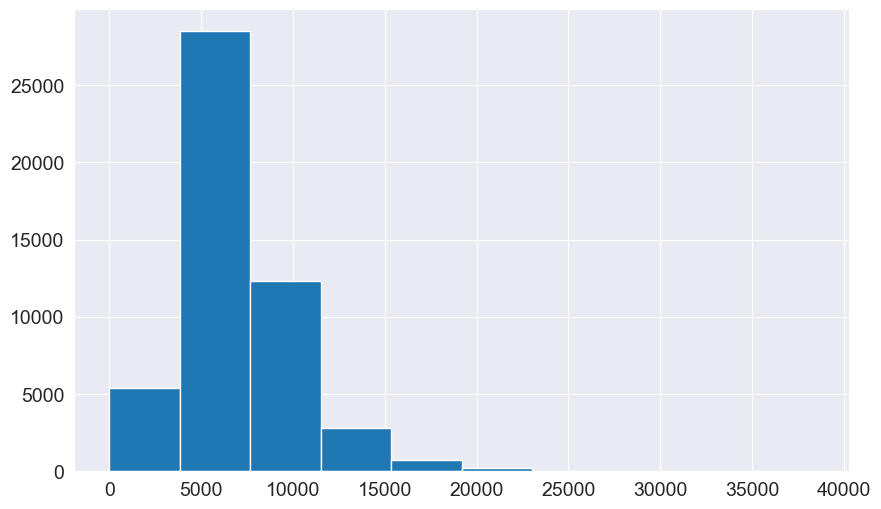

In [44]:
plt.hist(merged_train_data.Sales.sample(50000))

We can see GB is better because of residual calculation, as with every iteration each tree is reducing the RMSE as it's trying to reduce errors of the previious tress in comparison with RF, where each tress has to learn the entire relationship.

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [50]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

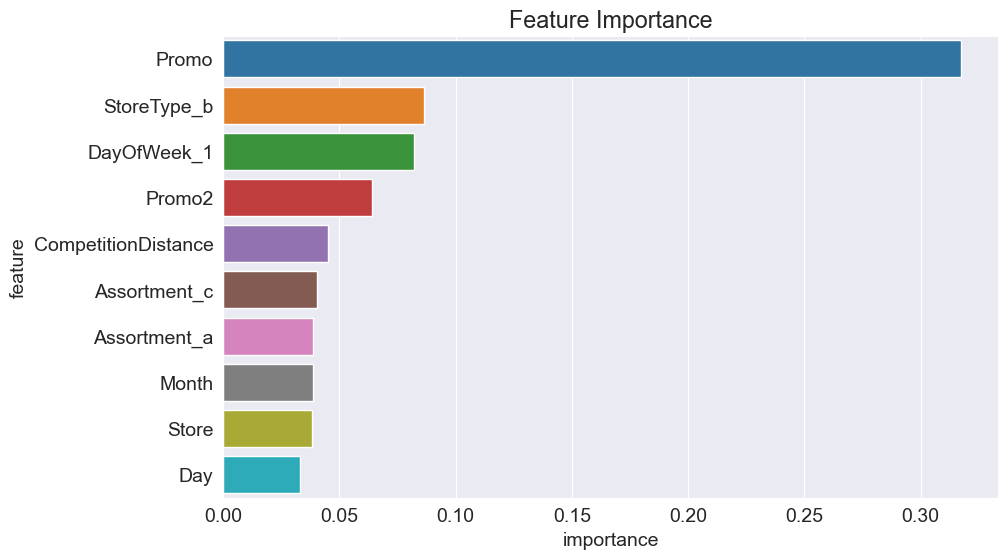

In [51]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

##### Conclusion made are:

- Promo2 have significant importance in our prediction. Also CompetitionDistance as we have choosed right columns for our model building.
- Further even the Month, and Day columns are useful rather than Date.

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [52]:
from sklearn.model_selection import KFold

# Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse


Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [53]:
kfold = KFold(n_splits=5)

In [54]:
models = []

# Performing k-fold cross-validation. (20% - Validation set)
for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2352.216448531526, Validation RMSE: 2424.6228916973314
Train RMSE: 2406.709513789309, Validation RMSE: 2451.9646038059277
Train RMSE: 2365.7354745443067, Validation RMSE: 2336.984157073758
Train RMSE: 2366.4732092777763, Validation RMSE: 2460.8995475901697
Train RMSE: 2379.3752997474626, Validation RMSE: 2440.665320626728


Let's also define a function to average predictions from the 5 different models.

In [55]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [56]:
preds = predict_avg(models, X)
preds

array([8021.374 , 7577.715 , 8747.863 , ..., 7615.0303, 7924.784 ,
       9600.297 ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

Note: I have used K-Fold Validation Method just for the understanding purpose but it is not useful here as we are working with large dataset with millions of rows. Also, K-fold may not be the optimal strategy here because we are working with time order data. So, ideally our validation set should ideally reflect or should be closer to what kind of data the model will see in real life replicate our test set so that we can get better result.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [58]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [60]:
print("n_estimator: 10")
test_params(n_estimators=10)

n_estimator: 10
Train RMSE: 2355.2396300806563, Validation RMSE: 2373.4359999560293


In [61]:
print("n_estimator: 30")
test_params(n_estimators=30)

n_estimator: 30
Train RMSE: 1928.512122206004, Validation RMSE: 1944.979045514706


In [63]:
print("n_estimators: 100") 
test_params(n_estimators=100)


n_estimators: 100
Train RMSE: 1212.6972611411566, Validation RMSE: 1223.9232414691571


In [62]:
print("n_estimators: 240")
test_params(n_estimators=240)

n_estimators: 240
Train RMSE: 908.1403147178614, Validation RMSE: 928.1068757290271


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [64]:
test_params(max_depth=2)


Train RMSE: 2344.058989074652, Validation RMSE: 2365.4640179308576


In [65]:
test_params(max_depth=5)

Train RMSE: 1465.881170165835, Validation RMSE: 1471.3197871728757


In [66]:
test_params(max_depth=10)


Train RMSE: 690.7957307378564, Validation RMSE: 784.1039096360479


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [67]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5041.7420233824905, Validation RMSE: 5056.541881683784


In [68]:
test_params(n_estimators=50, learning_rate=0.25)

Train RMSE: 1692.2417537213657, Validation RMSE: 1704.2523715178975


In [69]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1158.9769676955218, Validation RMSE: 1174.1065161947427


## Making Predictions on Test set

Let's train a final model on the entire training set with custom hyperparameters. 

In [70]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators= 300, 
                     learning_rate=0.25, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [71]:
%%time
model.fit(X, targets)

Wall time: 2min 24s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Now that the model is trained, we can make predictions on the test set.

In [72]:
model.predict(X_test)

array([ 3924.8125,  8379.977 ,  9181.153 , ...,  6720.726 , 23676.81  ,
        7712.5664], dtype=float32)

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this project:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters
